In [110]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Identifikujte aktivní a neaktivní stanice

In [111]:
df = pd.read_csv("J:/edinburgh_bikes.csv")

In [112]:
# Zjistit datum poslední výpůjčky. Poté určit hranici, co je ještě aktivní stanice.
# Upravíme časový formát z '2018-09-15 08:52:05.960000+00:00' na '2018-09-15'.
df['started_at'] = df['started_at'].str.split(' ').str[0]
df['ended_at'] = df['ended_at'].str.split(' ').str[0]

# Vybereme pouze stanice, které byly aktivní (sloupec ended_at) alespoň k datu 2020-10-01.
activeStationsList = []
df_temp = df[df["ended_at"] >= '2020-10-01']
activeStationsList = list(df_temp.end_station_id.unique())

# Vytvoříme dataframe pouze s aktivními stanicemi.
df_active_stations = df[df['start_station_id'].isin(activeStationsList)]
df_active_stations.head(5)

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,2018-09-15,2018-09-15,1182,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,259,St Andrew Square,North East corner,55.954728,-3.192653
1,2018-09-15,2018-09-15,995,259,St Andrew Square,North East corner,55.954749,-3.192774,262,Canonmills,near Tesco's,55.962804,-3.196284
2,2018-09-15,2018-09-15,3466,262,Canonmills,near Tesco's,55.962804,-3.196284,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116
5,2018-09-16,2018-09-16,228,253,Kings Building 2,Sanderson Building,55.923202,-3.171646,252,Kings Buildings 1,Grant Institute,55.924185,-3.173831
6,2018-09-16,2018-09-16,366,252,Kings Buildings 1,Grant Institute,55.924185,-3.173831,254,Kings Building 3,Kings Building House,55.923479,-3.175385


# Identifikujte nejfrekventovanější stanice

In [235]:
# Spočítáme kolikrát bylo v každé stanici kolo půjčeno a kolikrát vráceno.
station_freqeuncy = (df_active_stations
                        .agg({'start_station_id': 'value_counts', 'end_station_id': 'value_counts'})
                        .dropna()
# Výsledné hodnoty poté sečteme.
                        .apply(lambda row: row['start_station_id'] + row['end_station_id'], axis=1)
                        .astype(int)
                        .sort_values())

In [236]:
# Numpy array převedeme do dataframe
df_station_freqeuncy = (station_freqeuncy.to_frame()
                                            .reset_index()
                                            .rename(columns={'index': 'start_station_id', 0: 'frequency'}))

In [237]:
# Spojíme df_station_freqeuncy a df_active_stations
df_station_freqeuncy = (pd.merge(df_station_freqeuncy, df_active_stations[['start_station_id','start_station_name']], 
                                 how='inner', on='start_station_id'))

In [239]:
# Vymažeme duplikátní hodnoty
df_station_freqeuncy = (df_station_freqeuncy.loc[pd.DataFrame(
                                                np.sort(df_station_freqeuncy[['start_station_id']],1),
                                                index=df_station_freqeuncy.index)
                                                .drop_duplicates(keep='first').index])

df_station_freqeuncy.sort_values(by='frequency', ascending=False).head(5)

,start_station_id,frequency,start_station_name
282982,265,22487,Meadows East
274984,1728,18004,Portobello - Kings Road
266900,250,17782,Victoria Quay
256576,259,16106,St Andrew Square
245631,248,15854,Bristo Square


# Identifikujte stanice, na kterých se kola hromadí a stanice, kde potenciálně chybí.

In [189]:
# Spočítáme kolikrát bylo v každé stanici kolo půjčeno a kolikrát vráceno.
station_return = (df_active_stations.agg({'start_station_id': 'value_counts', 'end_station_id': 'value_counts'})
                                       .dropna()
# Výsledné hodnoty poté od sebe odečteme.
                                       .apply(lambda row: row['end_station_id'] - row['start_station_id'], axis=1)
                                       .astype(int)
                                       .sort_values())

In [190]:
# Numpy array převedeme do dataframe
df_station_return = (station_return.to_frame()
                                      .reset_index()
                                      .rename(columns={'index': 'start_station_id', 0: 'return'}))

In [229]:
# Spojíme df_station_return a df_active_stations
df_station_return = (pd.merge(df_station_return, df_active_stations[['start_station_id','start_station_name']], 
                              how='inner', on='start_station_id'))
df_station_return.head(5)

,start_station_id,return,start_station_name_x,start_station_name_y
0,248,-6061,Bristo Square,Bristo Square
1,248,-6061,Bristo Square,Bristo Square
2,248,-6061,Bristo Square,Bristo Square
3,248,-6061,Bristo Square,Bristo Square
4,248,-6061,Bristo Square,Bristo Square


In [195]:
# Vymažeme duplikátní hodnoty
df_station_return = (df_station_return.loc[pd.DataFrame(
                                        np.sort(df_station_return[['start_station_id']],1),
                                        index=df_station_return.index)
                                        .drop_duplicates(keep='first').index])
df_station_return.head(5)
# Kladná hodnota u stanice znamená, že zákazníci do dané stanice spíše kola vrací než si je vypůjčují (end_station_id > start_station_id)
# Záporná hodnota ukazuje, že kola k vypůjčení mohou potencionálně scházet (start_station_id > end_station_id)

,start_station_id,return,start_station_name
0,248,-6061,Bristo Square
10999,259,-4558,St Andrew Square
21371,247,-3372,Charlotte Square
28205,189,-2915,City Chambers
32810,265,-2854,Meadows East


# Spočítejte vzdálenosti mezi jednotlivými stanicemi

In [80]:
from itertools import combinations

In [175]:
# Spojíme df_station_geo a df_active_stations
df_station_geo = pd.DataFrame(activeStationsList).rename(columns={0: 'start_station_id'})
df_station_geo = pd.merge(df_station_geo, df_active_stations[['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude']], how='inner', on='start_station_id')
df_station_geo.head(5)

,start_station_id,start_station_name,start_station_latitude,start_station_longitude
0,1102,Haymarket Station,55.945582,-3.218192
1,1102,Haymarket Station,55.945582,-3.218192
2,1102,Haymarket Station,55.945582,-3.218192
3,1102,Haymarket Station,55.945582,-3.218192
4,1102,Haymarket Station,55.945582,-3.218192


In [176]:
# Vymažeme duplikátní hodnoty
df_station_geo = (df_station_geo.loc[pd.DataFrame(np.sort(df_station_geo[['start_station_id']],1),
                                        index=df_station_geo.index)
                                        .drop_duplicates(keep='first').index]
                 .rename(columns={'start_station_id': 'id', 'start_station_name': 'station', 
                                  'start_station_latitude': 'latitude', 'start_station_longitude': 'longitude'}))
df_station_geo.head(5)

,id,station,latitude,longitude
0,1102,Haymarket Station,55.945582,-3.218192
2241,1744,Morningside Road,55.927985,-3.209750
4793,1025,Dundee Terrace,55.939710,-3.220589
10170,262,Canonmills,55.962804,-3.196284
17759,1818,Dynamic Earth,55.951089,-3.175725


In [177]:
# Vytvoříme všechny možné kombinace bez opakování
df_station_pairs = pd.DataFrame(list(combinations(df_station_geo.station, 2)), columns=['start_station', 'end_station'])
df_station_pairs.head(5)

,start_station,end_station
0,Haymarket Station,Morningside Road
1,Haymarket Station,Dundee Terrace
2,Haymarket Station,Canonmills
3,Haymarket Station,Dynamic Earth
4,Haymarket Station,Castle Terrace


In [178]:
# Spojíme df_station_pairs a df_station_geo
df_station_pairs = (df_station_pairs.join(df_station_geo.set_index('station').add_prefix('start_'), on='start_station')
                   .join(df_station_geo.set_index('station').add_prefix('end_'), on='end_station'))
df_station_pairs.head(5)

,start_station,end_station,start_id,start_latitude,start_longitude,end_id,end_latitude,end_longitude
0,Haymarket Station,Morningside Road,1102,55.945582,-3.218192,1744,55.927985,-3.209750
1,Haymarket Station,Dundee Terrace,1102,55.945582,-3.218192,1025,55.939710,-3.220589
2,Haymarket Station,Canonmills,1102,55.945582,-3.218192,262,55.962804,-3.196284
3,Haymarket Station,Dynamic Earth,1102,55.945582,-3.218192,1818,55.951089,-3.175725
4,Haymarket Station,Castle Terrace,1102,55.945582,-3.218192,296,55.946766,-3.202038


In [179]:
# Spočítáme rozdíly v zeměpisné šířce (latitude) a délce (longitude) pro každou z dvojic.
df_lat_distance = (df_station_pairs.apply(lambda row: row['start_latitude'] - row['end_latitude'], axis=1)
         .to_frame()
         .rename(columns={0: 'distance_latitude'}))

df_lon_distance = (df_station_pairs.apply(lambda row: row['start_longitude'] - row['end_longitude'], axis=1)
         .to_frame()
         .rename(columns={0: 'distance_longitude'}))

# Výsledné hodnoty připojíme k df_stations_pairs.
df_station_pairs = df_station_pairs.merge(df_lat_distance, how='outer', left_index=True, right_index=True)
df_station_pairs = df_station_pairs.merge(df_lon_distance, how='outer', left_index=True, right_index=True)

df_station_pairs.head(5)

,start_station,end_station,start_id,start_latitude,start_longitude,end_id,end_latitude,end_longitude,distance_latitude,distance_longitude
0,Haymarket Station,Morningside Road,1102,55.945582,-3.218192,1744,55.927985,-3.209750,0.017597,-0.008442
1,Haymarket Station,Dundee Terrace,1102,55.945582,-3.218192,1025,55.939710,-3.220589,0.005872,0.002397
2,Haymarket Station,Canonmills,1102,55.945582,-3.218192,262,55.962804,-3.196284,-0.017222,-0.021908
3,Haymarket Station,Dynamic Earth,1102,55.945582,-3.218192,1818,55.951089,-3.175725,-0.005507,-0.042467
4,Haymarket Station,Castle Terrace,1102,55.945582,-3.218192,296,55.946766,-3.202038,-0.001184,-0.016154


In [181]:
# Pomocí Haversinova vzorce spočítáme vzdálenosti mezi jednotlivými stanicemi
R = 6373.0

a = (np.sin(df_station_pairs['distance_latitude']* np.pi/180 / 2)**2
     + np.cos(df_station_pairs['start_latitude']* np.pi / 180.0) 
     * np.cos(df_station_pairs['end_latitude']* np.pi / 180.0) 
     * np.sin(df_station_pairs['distance_longitude']* np.pi / 180.0 / 2)**2)
c = 2 * np.arcsin(np.sqrt(a))
distance = R * c

In [182]:
# Numpy array převedeme do pandas dataframe
df_distance = distance.to_frame().rename(columns={0: 'distance'})

In [183]:
# Spojíme df_stations_distance s distance.
df_stations_distance = df_station_pairs.merge(df_distance, how='outer', left_index=True, right_index=True)
df_stations_distance = df_stations_distance.reset_index(drop=True)
# Zobrazíme 10 od sebe nejvzdálenějších stanic
df_stations_distance[['start_station', 'end_station', 'distance']].sort_values(by='distance', ascending=False).head(10)

,start_station,end_station,distance
3972,Musselburgh Brunton Hall,Port Edgar Marina,22.376626
3941,Musselburgh Brunton Hall,Hopetoun Road,22.149705
3975,Musselburgh Brunton Hall,Forth Bridge Visitors Centre,22.037338
5168,Musselburgh Lidl,Port Edgar Marina,21.881772
5952,Queen Margaret University,Port Edgar Marina,21.875782
3976,Musselburgh Brunton Hall,Tesco Ferrymuir,21.798645
3973,Musselburgh Brunton Hall,The Loan,21.728948
5137,Musselburgh Lidl,Hopetoun Road,21.653197
5319,Hopetoun Road,Queen Margaret University,21.631092
5171,Musselburgh Lidl,Forth Bridge Visitors Centre,21.539293


# Jak dlouho trvá jedna výpůjčka?

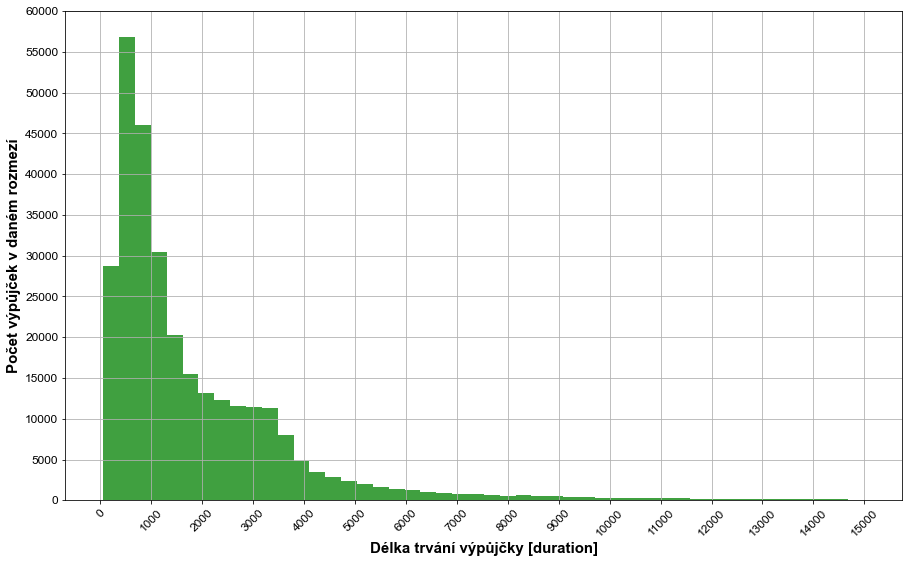

In [196]:
# Najděte odlehlé hodnoty, zobrazte histogram pomocí duration [sec]

# Z dat byly vyloučeny (duration) hodnoty mezi 15 000 až 1 373 043 sekund (1769 z celkových 320325 hodnot).
# Ve většině případů se jedná o výpůjčky kol, které zákazník zapomněl vrátit v zamýšleném čase a výrazně zkreslovaly histogram.
df_active_stations = df_active_stations[df_active_stations['duration'] <= 15000]

x = df_active_stations['duration'].to_numpy()

fig, ax = plt.subplots(figsize=(15, 9))

n, bins, patches = plt.hist(x, 48, density=False, facecolor='g', alpha=0.75)

plt.ylabel('Počet výpůjček v daném rozmezí', fontsize = 15, weight='bold')
plt.xlabel('Délka trvání výpůjčky [duration]', fontsize = 15, weight='bold')

plt.grid(True)
plt.xticks(np.arange(0, 15001, step=1000), rotation=45, fontsize = 12)
plt.yticks(np.arange(0, 60001, step=5000), fontsize = 12)
plt.style.use('seaborn')

plt.show()

# Zobrazte vývoj poptávky po půjčování kol v čase.

In [203]:
# Pro každé datum vybereme unikátní hodnotu a spočítáme kolikrát se dané datum nachází v df_active_stations
unique, counts = np.unique(df_active_stations.started_at.values, return_counts=True)
tempDict = dict(zip(unique, counts))

# Python dictionary převedeme pandas dataframe
df_daily_demand = (pd.DataFrame.from_dict(tempDict, orient='index').reset_index()
                       .rename(columns={"index": "date", 0: "daily_demand"}))

# Pro každý rok vytvoříme vlastní dataframe
df_daily_demand_2018 = df_daily_demand[df_daily_demand['date'] <= '2018-12-31']
df_daily_demand_2019 = df_daily_demand[(df_daily_demand['date']> '2018-12-31') & (df_daily_demand['date'] <= '2019-12-31')]
df_daily_demand_2020 = df_daily_demand[df_daily_demand['date'] >= '2020-01-01']

KeyError: <zip object at 0x000001D6D4500EC0>

In [216]:
# Pro každé datum vybereme unikátní hodnotu a spočítáme kolikrát se dané datum nachází v df_active_stations
unique, counts = np.unique(df_active_stations.started_at.values, return_counts=True)
df_daily_demand = (pd.DataFrame(counts, unique).reset_index()
                                               .rename(columns={'index': 'date', 0: 'daily_demand'}))

# Pro každý rok vytvoříme vlastní dataframe
df_daily_demand_2018 = df_daily_demand[df_daily_demand['date'] <= '2018-12-31']
df_daily_demand_2019 = df_daily_demand[(df_daily_demand['date']> '2018-12-31') & (df_daily_demand['date'] <= '2019-12-31')]
df_daily_demand_2020 = df_daily_demand[df_daily_demand['date'] >= '2020-01-01']

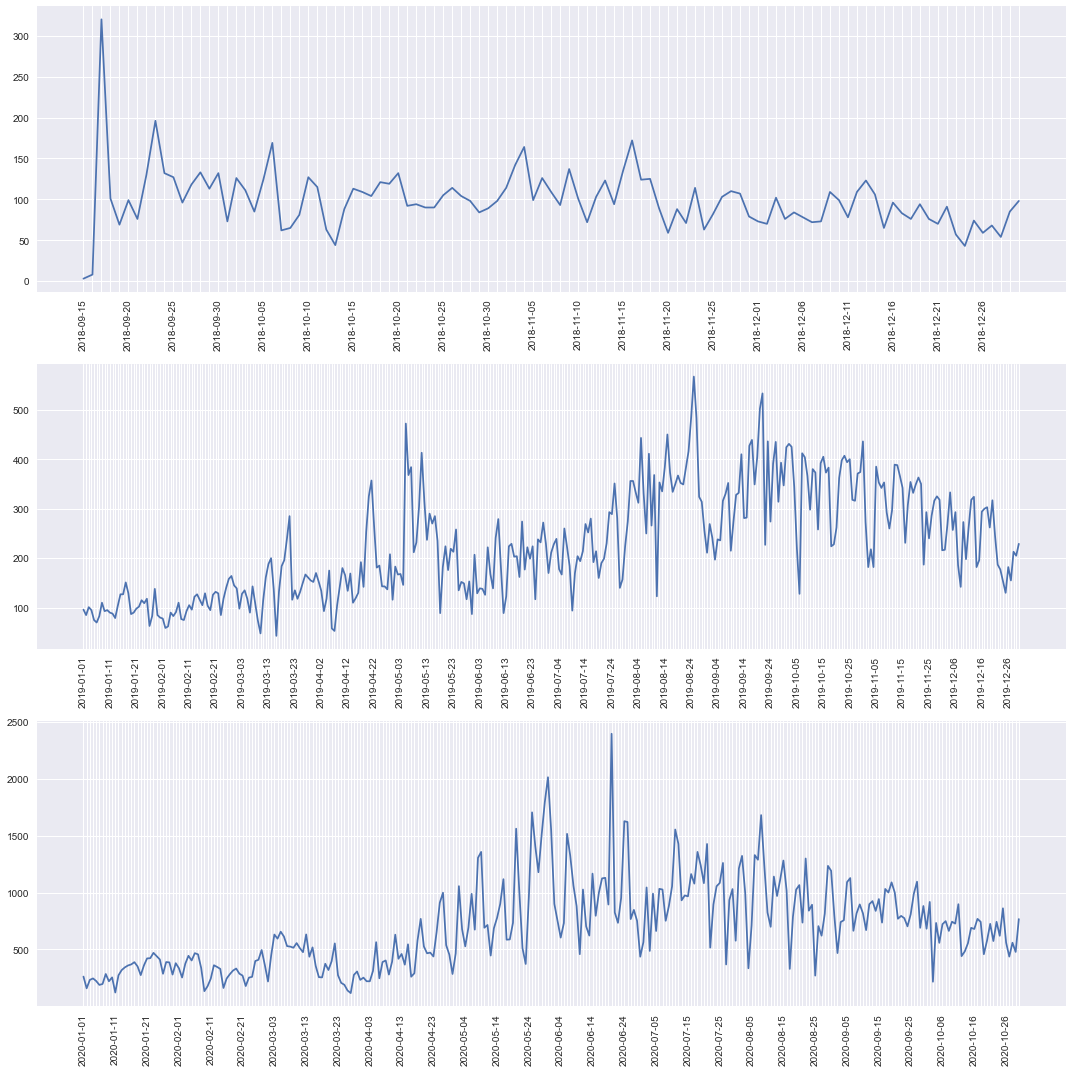

In [217]:
# Vývoj poptávky zobrazíme v plot grafu.
fig1, axs = plt.subplots(ncols=1, nrows=3, figsize=(15,15))

axs[0].plot(df_daily_demand_2018['date'], df_daily_demand_2018['daily_demand'])
axs[1].plot(df_daily_demand_2019['date'], df_daily_demand_2019['daily_demand'])
axs[2].plot(df_daily_demand_2020['date'], df_daily_demand_2020['daily_demand'])

axs[0].set_xticklabels(list(df_daily_demand_2018['date']), rotation=90)
for i, t in enumerate(axs[0].get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)

axs[1].set_xticklabels(list(df_daily_demand_2019['date']), rotation=90)
for i, t in enumerate(axs[1].get_xticklabels()):
    if (i % 10) != 0:
        t.set_visible(False)
        
axs[2].set_xticklabels(list(df_daily_demand_2020['date']), rotation=90)
for i, t in enumerate(axs[2].get_xticklabels()):
    if (i % 10) != 0:
        t.set_visible(False)
        
plt.tight_layout()
plt.show()

# Identifikujte příčiny výkyvů poptávky

# Zjistěte vliv počasí na poptávku po kolech

In [218]:
# temp [°c], feels [°c], wind [km/h], gust [km/h], rain [mm], humidity [%], cloud [%], pressure [mb]
#df_weather = pd.read_csv('https://raw.githubusercontent.com/MichalLeh/Edinburgh-bikes-project/main/edinburgh_weather.csv')
df_weather = pd.read_csv("J:/edinburgh_weather.csv")
df_weather.head(5)

,time,temp,feels,wind,gust,rain,humidity,cloud,pressure,vis,date
0,00:00,11 °c,11 °c,9 km/h from S,19 km/h,0.0 mm,79%,13%,1020 mb,Excellent,2018-09-01
1,03:00,13 °c,12 °c,11 km/h from SSW,19 km/h,0.0 mm,76%,96%,1020 mb,Excellent,2018-09-01
2,06:00,14 °c,13 °c,11 km/h from SSW,19 km/h,0.0 mm,84%,100%,1020 mb,Excellent,2018-09-01
3,09:00,14 °c,13 °c,14 km/h from SSW,23 km/h,0.1 mm,88%,78%,1021 mb,Excellent,2018-09-01
4,12:00,16 °c,16 °c,15 km/h from SSW,22 km/h,0.0 mm,87%,87%,1021 mb,Excellent,2018-09-01


In [219]:
# Z dataframu odstraníme jednotky [°c],[km/h],[mm],[%],[mb]
df_weather = (df_weather[['time', 'date', 'temp', 'feels', 'wind', 'gust', 'rain', 'humidity', 'cloud', 'pressure']]
                           .replace(to_replace ='[^0-9\:\-\.]', value = '', regex = True))

In [220]:
# Hodnoty převedeme do numerického formátu (int, float)
cols = ['temp', 'feels', 'wind', 'gust', 'rain', 'humidity', 'cloud', 'pressure']

df_weather[cols] = df_weather[cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [221]:
# Spočítáme průmernou hodnotu pro všechny přírodní jevy za každý den
df_weather = df_weather.groupby('date')[['temp', 'feels', 'wind', 'gust', 'rain', 'humidity', 'cloud','pressure']].mean().reset_index()
df_weather.head(5)

,date,temp,feels,wind,gust,rain,humidity,cloud,pressure
0,2018-09-01,14.375,14.000,12.125,20.125,0.0125,84.875,77.625,1020.875
1,2018-09-02,16.500,16.625,12.875,21.000,0.0500,87.875,70.625,1019.875
2,2018-09-03,11.875,11.500,8.625,13.125,0.0375,87.625,70.750,1023.250
3,2018-09-04,11.250,13.375,5.000,6.750,0.0000,75.125,6.750,1024.375
4,2018-09-05,12.500,12.625,9.375,14.125,0.0500,79.750,27.250,1022.125


In [222]:
# Spojíme dohromady dataframy df_weather a df_daily_demand prostřednictvím klíče 'date'
df_demand_weather = pd.merge(df_weather, df_daily_demand, on=['date'])
df_demand_weather.head(5)

,date,temp,feels,wind,gust,rain,humidity,cloud,pressure,daily_demand
0,2018-09-15,10.500,8.500,14.875,23.500,0.1250,83.875,58.125,1017.375,3
1,2018-09-16,12.875,10.625,26.500,43.125,0.1250,81.500,79.500,1008.875,8
2,2018-09-17,13.875,13.125,18.000,29.875,0.0250,83.000,66.125,1006.375,320
3,2018-09-18,14.125,13.500,16.875,28.500,0.2375,86.875,57.750,996.125,101
4,2018-09-19,11.750,8.625,34.750,55.625,0.3625,75.750,52.250,995.875,69


In [223]:
# Nakonec zjistíme vliv počasí na poptávku po kolech
df_demand_weather.corr().loc[['daily_demand'], ['temp', 'feels', 'wind', 'gust', 'rain', 'humidity', 'cloud', 'pressure']]

,temp,feels,wind,gust,rain,humidity,cloud,pressure
daily_demand,0.430555,0.443116,-0.201238,-0.248958,-0.054465,-0.206595,-0.043994,0.107691


# Půjčují si lidé kola více o víkendu než během pracovního týdne?

In [225]:
# Převedeme datum 'date' na den v týdnu
df_demand_weather['date'] = pd.to_datetime(df_demand_weather['date'])
df_demand_weather['day_name'] = df_demand_weather['date'].dt.day_name()
df_demand_weather.head(5)

,date,temp,feels,wind,gust,rain,humidity,cloud,pressure,daily_demand,day_name
0,2018-09-15,10.500,8.500,14.875,23.500,0.1250,83.875,58.125,1017.375,3,Saturday
1,2018-09-16,12.875,10.625,26.500,43.125,0.1250,81.500,79.500,1008.875,8,Sunday
2,2018-09-17,13.875,13.125,18.000,29.875,0.0250,83.000,66.125,1006.375,320,Monday
3,2018-09-18,14.125,13.500,16.875,28.500,0.2375,86.875,57.750,996.125,101,Tuesday
4,2018-09-19,11.750,8.625,34.750,55.625,0.3625,75.750,52.250,995.875,69,Wednesday


In [227]:
# Spočítáme poptávku po kolech 'daily_demand' pro každý den v týdnu
dailyDemand = (df_demand_weather.groupby(by=["day_name"])["daily_demand"]
               .sum()
               .to_frame()
               .sort_values(by='daily_demand')
               .reset_index()
              )

In [228]:
dailyDemand

,day_name,daily_demand
0,Monday,38855
1,Tuesday,39302
2,Wednesday,41249
3,Friday,42272
4,Thursday,43000
5,Sunday,43569
6,Saturday,47400
